## Sea Level Rise Scenarios:  API Retrieval and Plotting

Written by Julia Engdahl - julia.engdahl@noaa.gov

We will be using the Center for Operational Oceanographic Products and Services (CO-OPS) Derived Product API (DPAPI)

Input and output documentation can be found in the [CO-OPS Data API](https://api.tidesandcurrents.noaa.gov/api/prod/), [CO-OPS Derived Product API v0.1](https://api.tidesandcurrents.noaa.gov/dpapi/prod/) and the [CO-OPS Metadata API](https://api.tidesandcurrents.noaa.gov/mdapi/prod/).


Standard templates are available within the [CO-OPS API URL Builder](https://tidesandcurrents.noaa.gov/api-helper/url-generator.html), but this notebook is designed to give you more flexiblity through building our own api template to generate queries from our Data API, MetaData API, and Derived Product API.

In this Notebook, we'll show you how to replicate regional scenario plots from [CO-OPS Sea Level Trends Map](https://tidesandcurrents.noaa.gov/sltrends/sltrends.html). 

For this example, we'll be using [Sewells Point, VA (8638610)](https://tidesandcurrents.noaa.gov/sltrends/sltrends_station.shtml?plot=scenario&id=8638610).

#### You'll need the following packages to plot each visualization.

In [1]:
import datetime as dt
import requests
import time as time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

#### In this step, we're defining the 'Station ID' that we'll use for the plots we're creating and each of our API calls. 

In [2]:
station = "8638610"

#### Next, we'll pull from the CO-OPS Data API to get Mean Sea Level (MSL) from the Product Monthly Means.

In [3]:
begin_date = "19600101"
end_date = "20211231"
product = "monthly_mean"
datum = "msl"
server = "https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?"

myurl = (server + "begin_date=" + begin_date +"&end_date=" + end_date +"&station=" + station +
         "&product=" + product +"&datum=" + datum + "&time_zone=gmt&units=english&format=json")

# Use "requests" to get the Monthly MSL Data

urlResponse = requests.get(myurl)
content=urlResponse.json()

# Assign data to variables.

mydata = content['data']
mymeta= content['metadata']

station_name=mymeta['name']
station_id=mymeta['id']

# Make it a Dataframe
mydf = pd.DataFrame(mydata)

#### Now, we're converting Monthly Means to Annual Means so we have one value per year. 

In [4]:
 # Covert Monthly MSL to Annual MSL
    
df_msl=mydf.loc[:,['year','month','MSL']]

msl=df_msl['MSL']
year=df_msl['year']
month=df_msl['month']


msl.index=year

year=year.astype('int')
month=month.astype('int')
msl=msl.astype('float')

msl_group_sizes=msl.groupby([msl.index]).count()

msl_annual=msl.groupby([msl.index]).mean()

# Make Annual MSLs with less than or equal to 6 months of MSL data Nulls 

msl_annual[msl_group_sizes<=6]=np.nan



#### In this step, we're pulling the updated scearios from the Derived Data API (DPAPI) - More information about these scenarios can be found here: [2022 Sea Level Rise Tech Report](https://oceanservice.noaa.gov/hazards/sealevelrise/sealevelrise-tech-report-sections.html). 

In [5]:
# Get SLR Projections from 2022 Tech Report
    
product = "slr_projections"

server = "https://api.tidesandcurrents.noaa.gov/dpapi/prod/webapi/product/"


affil = "US"

units='english'

report_year='2022'

myurl=(server+ product  + ".json?"+"units="+units+"&station=" + station + "&report_year=" + report_year+"&affil=" + affil)
# Use requests to get the data
urlResponse = requests.get(myurl)
content=urlResponse.json()

# Assign data to variables 
mydata = content['SlrProjections']


# Make it a Dataframe
mydf_slr_projection = pd.DataFrame(mydata)

#### For this step, we're applying an offset to one station's the MSL value. All updated scenarios begin in 2005, so we're shifting the observed data to also center zero around 2005.

#### Please note: If using Station ID 1770000, the data will need to be shifted to 2012 to account for an earthquake that drastically changed regional sea level trends. 

In [6]:
if int(station) == 1770000:
    epoch_10_14 = msl_annual['2010':'2014']
    epoch_offset=np.nanmean(epoch_10_14)
else:
    epoch_96_14=msl_annual['1996':'2014']
    epoch_offset=np.nanmean(epoch_96_14)


msl_annual_offset = msl_annual - epoch_offset

rmsl = 0 - epoch_offset

#### This step pulls individual scenarios from the 'mydf_slr_projection' dataframe and converts them from inches to feet. 

In [7]:
 # Break down SLR Projections by Scenario
    
scenario_low=mydf_slr_projection[mydf_slr_projection['scenario']=='Low'] 
scenario_low.reset_index(inplace=True,drop=True)
scenario_intlow=mydf_slr_projection[mydf_slr_projection['scenario']=='Intermediate-Low']
scenario_intlow.reset_index(inplace=True,drop=True)
scenario_int=mydf_slr_projection[mydf_slr_projection['scenario']=='Intermediate']
scenario_int.reset_index(inplace=True,drop=True)
scenario_inthigh=mydf_slr_projection[mydf_slr_projection['scenario']=='Intermediate-High']
scenario_inthigh.reset_index(inplace=True,drop=True)
scenario_high=mydf_slr_projection[mydf_slr_projection['scenario']=='High']
scenario_high.reset_index(inplace=True,drop=True)

projection_year=scenario_low['projectionYear'].astype('int')
projection_year_unique=pd.Series(projection_year.unique())

# Convert to inches to ft
scenario_low_rslproj=scenario_low['projectionRsl']*0.0833
scenario_intlow_rslproj=scenario_intlow['projectionRsl']*0.0833
scenario_int_rslproj=scenario_int['projectionRsl']*0.0833
scenario_inthigh_rslproj=scenario_inthigh['projectionRsl']*0.0833
scenario_high_rslproj=scenario_high['projectionRsl']*0.0833

#### Now, we'll grab the MSL datum, and if it exists, the NAVD88 datum as well. 

In [8]:
 #Grab datums from meta data api
    
datums_server = "https://api.tidesandcurrents.noaa.gov/mdapi/prod/webapi/stations/"

datums_product='Datums'
units = 'english'

datums_url=(datums_server+ station +"/datums.json?"+"units="+units)
datums_urlResponse = requests.get(datums_url)

datums_content=datums_urlResponse.json()


datums = datums_content['datums']
df_datum = pd.DataFrame(datums)
df_dat=df_datum.loc[:,['name','value']]

dMSL = df_dat[df_dat['name']=='MSL']['value'].values
dNAV = df_dat[df_dat['name']=='NAVD88']['value'].values

#### This step adjusts the 'rnav' regional variable to 'none' if it doesn't exist. If it does, this section will adjust 'rnav' to be on the same datum as the data. 

In [9]:
if dNAV.size==0:
    rnav = None

else:
    rnav = rmsl + ( dNAV -dMSL)


#### This step creates a unique series of years within the dataframe.

In [10]:
years_unique=pd.Series(year.unique()) #this creates a series of dates with msl data. 

#### This final step plots a station's observed mean sea level and regional scenarios alongside reference lines for MSL Datum, and if present, NAVD88. 

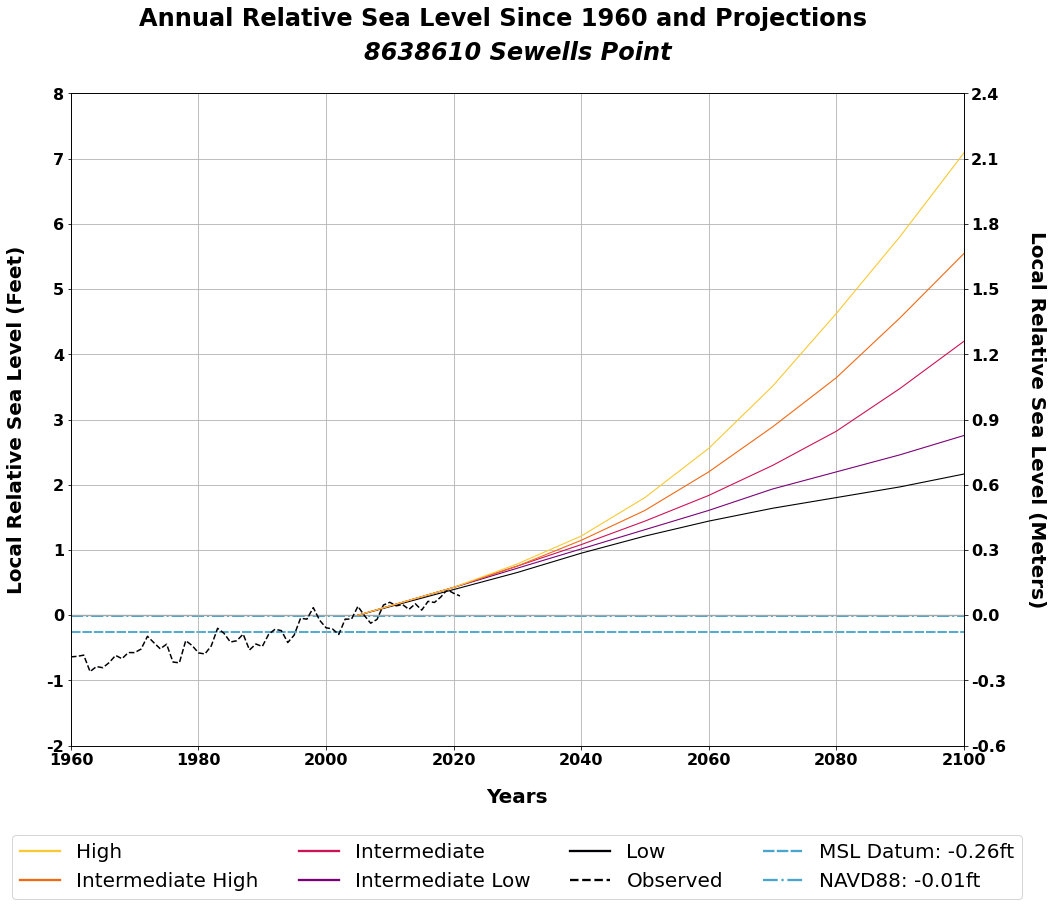

In [11]:
fig,ax=plt.subplots(figsize=(16,12))
    
    
lns6=ax.plot(years_unique,msl_annual_offset,color='#000004',linestyle='dashed',label='Observed',linewidth=1.5)
lns5=ax.plot(projection_year_unique,scenario_low_rslproj,color='#000004',label='Low',linewidth=1.1)
lns4=ax.plot(projection_year_unique,scenario_intlow_rslproj,color='#7a0177',label='Intermediate Low',linewidth=1.1)
lns3=ax.plot(projection_year_unique,scenario_int_rslproj,color='#ce1256',label='Intermediate',linewidth=1.1)
lns2=ax.plot(projection_year_unique,scenario_inthigh_rslproj,color='#f16913' ,label='Intermediate High',linewidth=1.1)
lns1=ax.plot(projection_year_unique,scenario_high_rslproj,color='#f8c932',label='High',linewidth=1.1)
ax.axhline(0,c='gray',linewidth=1.3,zorder=0)

if rnav == None:

    lns7 = plt.plot([1960,2100],[rmsl,rmsl],c='#1d91c0',linewidth=1.9,linestyle=(0, (5, 1)),alpha=0.8,label='MSL Datum: '+str(np.round(rmsl,3))+'ft',zorder=1)
#         ax.text(1963,rmsl,'MSL',color='gray',fontsize=15,va='bottom')
    lns=lns1+lns2+lns3+lns4+lns5+lns6+lns7
else:

    lns7 = plt.plot([1960,2100],[rmsl,rmsl],c='#1d91c0',linewidth=1.9,linestyle=(0, (5, 1)),alpha=0.8,label='MSL Datum: '+str(np.round(rmsl,3))+'ft',zorder=1)
#         ax.text(1963,rmsl,'MSL',color='gray',fontsize=15,va='bottom')


    lns8 = plt.plot([1960,2100],[rnav,rnav],c='#1d91c0',linewidth=1.9,linestyle='dashdot',alpha=0.8,label='NAVD88: '+str(np.round(rnav[0],3))+'ft',zorder=1)
#         ax.text(1963,rnav,'NAVD88',color='gray',fontsize=15,va='bottom')
    lns=lns1+lns2+lns3+lns4+lns5+lns6+lns7+lns8

labs = [l.get_label() for l in lns]


fig.suptitle('Annual Relative Sea Level Since 1960 and Projections',fontsize=24,fontweight="bold")
ax.set_title(station_id + " " + station_name+'\n',fontsize=24,fontweight="bold",style='italic') 

ax.set_xlim([1960,2100])
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontweight('bold') for label in labels]
[label.set_fontsize(16) for label in labels]
ax.set_xlabel('Years',fontsize=20,fontweight="bold")
ax.xaxis.labelpad=20


ax.set_ylabel('Local Relative Sea Level (Feet)',fontsize=20,fontweight="bold")
ax.yaxis.labelpad=20
#     if int(stn) == 9452210 or int(stn) == 9452400:
#         leg = ax.legend(lns,labs,loc="upper right",fontsize=20,shadow=True)
#     else:
#         leg = ax.legend(lns,labs,loc="upper left",fontsize=20,shadow=True)
leg = ax.legend(lns,labs,ncol=4,bbox_to_anchor=(0.5,-0.25),loc='lower center',fontsize=20)
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.3)


ax.grid(True)

ax2 = ax.twinx()

ax2.set_ylabel('Local Relative Sea Level (Meters)',fontsize=20,fontweight="bold",rotation=-90)
ax2.yaxis.labelpad=40

# set ylimits to account for white space

if int(station) >= 9410170 and int(station) <= 9452400 or int(station) >= 9454050 and int(station) <= 9455760 or int(station) >= 9457292 and int(station) <= 9497645:
    yticks=np.arange(-5,7+1,1)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks,fontsize=16,fontweight='bold')
    ax.set_ylim([-5,7])

    y2ticks=np.arange(-5,7+1,1)
    yy=np.round(y2ticks*0.3048,1)
    ax2.set_yticks(yy)
    ax2.set_yticklabels(yy,fontsize=16,fontweight='bold')
    ax2.set_ylim([-1.5,2.1])

elif int(station) == 9453220 or int(station) == 9455920:
    yticks=np.arange(-6,5+1,1)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks,fontsize=16,fontweight='bold')
    ax.set_ylim([-6,5])

    y2ticks=np.arange(-6,5+1,1)
    yy=np.round(y2ticks*0.3048,1)
    ax2.set_yticks(yy)
    ax2.set_yticklabels(yy,fontsize=16,fontweight='bold')
    ax2.set_ylim([-1.8,1.5])
else:
    yticks=np.arange(-2,8+1,1) 
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks,fontsize=16,fontweight='bold')
    ax.set_ylim([-2,8])

    y2ticks=np.arange(-2,8+1,1)
    yy=np.round(y2ticks*0.3048,1)
    ax2.set_yticks(yy)
    ax2.set_yticklabels(yy,fontsize=16,fontweight='bold')
    ax2.set_ylim([-0.6,2.4])